## Data challenge - Machine Learning for Geobiology
Paulina Körner

kaggle user name: Paulina Koerner

### 1. Abstract
(5 points)
- Should be understandable to anyone in the course.
- You don’t need to say everything you did, just say what the main idea was and what were one or two takeaways.

### 2. Introduction
(5 points)
- A description of the methods you used in the project and why.

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt

from sklearn import metrics 
from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_selection import SelectKBest, chi2
from sklearn.metrics import f1_score

### 3. Data pre-processing
(20 points)
- Did you standardize or normalize the data?
- Did you use all the features available or selected an optimal subset? If so how did you perform the feature selection?

#### Data: 
- 3000 samples
- each row is one sample
- 34 columns (mainly chemicals in rock sample)
- Label: 0 -> 'Miocene', 1 -> 'Paleogene', 2 -> 'Plio-Quaternary'
- Evaluating on F1 metric (not accuracy) – so try to optimize the F1 metric
- Look at feature importance 



In [2]:
# Import data sets
test = pd.read_csv('test.csv')
X_test = test.set_index('Id')
y_test = test.Id
print(X_test.shape)
#X_test.head()

(757, 33)


In [3]:
train = pd.read_csv('train.csv')
print(train.shape)
#train.head(10)
#print(train.columns)

(2271, 35)


In [4]:
#Check how many samples are from which time period
grouped = train.groupby(['Label']).count()
grouped.Id

Label
0     822
1    1061
2     388
Name: Id, dtype: int64

In [5]:
# check if dataframe is missing values
print(train.isnull().sum().sum())

0


In [6]:
# check if Id's are unique
ids = train.Id
print(ids.nunique())

2271


In [7]:
# check mean and variance of column values
columns = train.columns
variability = pd.DataFrame(data=columns, index=None, columns=["Column"])
means = train[columns].mean()
variability = means.to_frame().reset_index()
variability.columns = ["Columns", "Mean"]
variances = train[columns].var()
var_df = variances.to_frame().reset_index()
var_df.columns = ["Columns", "Variance"]
variability["Variance"] = var_df["Variance"]
variability = variability.round({'Mean': 1, 'Variance': 1})

#variability.head(34)

- The dataset contains outliers. 
- The data is not normally distributed.
- Can transform features by scaling each feature to a given range unding sklearn.preprocessing.MinMaxScaler()

In [8]:
"""
scaler = MinMaxScaler(feature_range=(0,1))

X = scaler.fit_transform(train.drop("Label", axis=1))
train_scaled= pd.DataFrame(X, columns=train.drop("Label", axis=1).columns, index=train.index)
train_scaled["Label"] = train["Label"]
train_scaled.head()
#print(train_scaled["Label"].unique())
"""

'\nscaler = MinMaxScaler(feature_range=(0,1))\n\nX = scaler.fit_transform(train.drop("Label", axis=1))\ntrain_scaled= pd.DataFrame(X, columns=train.drop("Label", axis=1).columns, index=train.index)\ntrain_scaled["Label"] = train["Label"]\ntrain_scaled.head()\n#print(train_scaled["Label"].unique())\n'

In [9]:
# Down sampln: select randomly equal number of rows for each label
"""
n = 388
label0 = train.loc[train['Label'] == 0]
label1 = train.loc[train['Label'] == 1]
label2 = train.loc[train['Label'] == 2]
print("Shape of label0: ", label0.shape)
print("Shape of label1: ", label1.shape)
print("Shape of label2: ", label2.shape)
print(" ")

label0_sampled = label0.sample(n=n)
label1_sampled = label1.sample(n=n)
print("Shape of label0_sampled: ",label0_sampled.shape)
print("Shape of label1_sampled: ",label1_sampled.shape)
print(" ")

train_sampled = pd.concat([label2, label0_sampled, label1_sampled])
print("Shape of train_sampled: ", train_sampled.shape)

# Shuffle rows
train = train_sampled.sample(frac=1)
train.head()
"""

'\nn = 388\nlabel0 = train.loc[train[\'Label\'] == 0]\nlabel1 = train.loc[train[\'Label\'] == 1]\nlabel2 = train.loc[train[\'Label\'] == 2]\nprint("Shape of label0: ", label0.shape)\nprint("Shape of label1: ", label1.shape)\nprint("Shape of label2: ", label2.shape)\nprint(" ")\n\nlabel0_sampled = label0.sample(n=n)\nlabel1_sampled = label1.sample(n=n)\nprint("Shape of label0_sampled: ",label0_sampled.shape)\nprint("Shape of label1_sampled: ",label1_sampled.shape)\nprint(" ")\n\ntrain_sampled = pd.concat([label2, label0_sampled, label1_sampled])\nprint("Shape of train_sampled: ", train_sampled.shape)\n\n# Shuffle rows\ntrain = train_sampled.sample(frac=1)\ntrain.head()\n'

##### Outlier detection

In [10]:

# Outlier detection with isolation Forest
from sklearn.ensemble import IsolationForest
clf = IsolationForest(random_state=0)
pred = clf.fit_predict(train) #identify outliers
train_cleaned = train[np.where(pred == 1, True, False)] # remove outliers where 1 represents inliers and -1 represents outliers
#train_cleaned.shape

##### Convert to train set

In [11]:
train_cleaned_id = train_cleaned.set_index('Id')
#train_cleaned_id = train.set_index('Id') # set index as Id
y = train_cleaned_id["Label"] #create y set with Labels
x = train_cleaned_id.drop(['Label'], axis = 1) # create x dataset without Labels

##### Feature Selection

In [12]:
kbest = SelectKBest(k=33)
kbest.fit_transform(x, y)
#X_test = kbest.transform(X_test)

array([[48.7 , 14.49,  8.76, ...,  4.69,  8.38,  3.18],
       [75.93, 13.01,  0.95, ...,  0.55,  2.13,  6.75],
       [58.92, 16.46,  5.87, ...,  2.31,  3.41,  9.66],
       ...,
       [63.26, 16.36,  5.92, ...,  2.26,  5.62,  3.84],
       [68.79, 13.12,  4.76, ...,  2.33,  1.99,  4.15],
       [68.23, 16.28,  3.56, ...,  1.54,  4.15,  4.03]])

{'Sm/Yb': 320.93386481124253, '(Sm/Yb)N': 320.3973272109341, '(La/Yb)N': 293.9616367013765, 'La/Yb': 293.8846357215445, 'La': 239.2664151201812, 'LaN': 238.7155781442083, 'CeN': 232.67726898207405, 'Ce': 232.61695526214538, 'Nb/Yb': 216.01414465516834, 'Nb': 155.70371857217455, 'Sm': 120.90867896360325, 'SmN': 120.71950891463344, 'Yb': 107.67378362745029, 'YbN': 107.67234876706569, 'Ti': 103.51667969827291, 'TiO2(LOI free)': 102.09686869162626, 'La/Sm': 93.18806169095353, 'SiO2(LOI free)': 61.23445800650728, 'SiO2': 59.59308795931548, 'MgO(LOI free)': 59.5930789074193, 'CaO': 51.639861061617125, 'CaO(LOI free)': 51.15636139059611, 'Rb/Sm': 40.39054566450408, 'Nb/La': 36.875479011276816, 'Fe2O3tot': 36.2093895464009, 'Fe2O3(LOI free)': 36.182567960372545, 'Nb/Rb': 22.677306885450857, 'La/Nb': 21.310459270148254, 'Na2O(LOI free)': 21.050119417519003, 'Rb': 18.834137633201408, 'Al2O3(LOI free)': 15.59498412986893, 'Al2O3': 14.726758652649913, 'Total': 10.222824468988215}


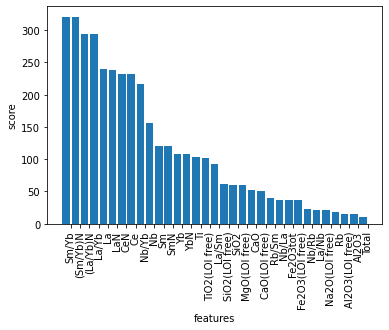

In [13]:
scores = kbest.scores_
features = kbest.feature_names_in_
feature_scores = {}

for i in range(len(scores)):
  feature_scores[features[i]] = scores[i]

feature_scores = sorted(feature_scores.items(), key=lambda x:x[1], reverse=True)
scores_sorted = dict(feature_scores)
print(scores_sorted)

#dict_scores = feature_scores
dict_scores = scores_sorted
x_plot = np.arange(len(dict_scores))
y_plot = dict_scores.values()
plt.bar(x_plot, y_plot)
plt.xticks(x_plot + 0.5, dict_scores.keys(), rotation='vertical')
plt.xlabel("features")
plt.ylabel("score")
plt.show()

There is no clear elbow visible so I won't to feature selection.

-------------------------------------------------------------------
------------------------------------------------------------------------


### 4. Modeling
(40 points)
- What are the model assumptions?
- Is there any evidence to support them?

#### K nearest neighbor

In [14]:
"""
# cross validation to select the optimal number of neighbors the KNN classifier should use
# Cross validation fits the model on a subset of the training data and predicts labels on the remaining training samples
# By repeating this operation with different k parameters, I can estimate which value fits our problem the best.

from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
import matplotlib.pyplot as plt

k_range = list(range(1, 31, 1))
param_grid = dict(n_neighbors=k_range)

grid = GridSearchCV(KNeighborsClassifier(), param_grid)
grid.fit(X_train, y_train)

mean_test_scores = grid.cv_results_['mean_test_score']
best_estimator = grid.best_estimator_
accuracy = grid.best_score_ *100

plt.plot(k_range, mean_test_scores, "bo")
#plt.axvspan(2.5, 3.5, color='green', alpha=0.5)
plt.title("Mean test score for each parameter")
plt.xlabel("parameters k")
plt.ylabel("mean test score")
plt.show()
print("Mean test scores for parameters k: ", mean_test_scores)
print(best_estimator)
print("Accuracy of best parameter: ",accuracy)
"""


'\n# cross validation to select the optimal number of neighbors the KNN classifier should use\n# Cross validation fits the model on a subset of the training data and predicts labels on the remaining training samples\n# By repeating this operation with different k parameters, I can estimate which value fits our problem the best.\n\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.neighbors import KNeighborsClassifier\nimport matplotlib.pyplot as plt\n\nk_range = list(range(1, 31, 1))\nparam_grid = dict(n_neighbors=k_range)\n\ngrid = GridSearchCV(KNeighborsClassifier(), param_grid)\ngrid.fit(X_train, y_train)\n\nmean_test_scores = grid.cv_results_[\'mean_test_score\']\nbest_estimator = grid.best_estimator_\naccuracy = grid.best_score_ *100\n\nplt.plot(k_range, mean_test_scores, "bo")\n#plt.axvspan(2.5, 3.5, color=\'green\', alpha=0.5)\nplt.title("Mean test score for each parameter")\nplt.xlabel("parameters k")\nplt.ylabel("mean test score")\nplt.show()\nprint("Mean test sco

In [15]:
"""
knn = KNeighborsClassifier(n_neighbors=3)
knn.fit(X_train, y_train)

# Accuracy
from sklearn.metrics import accuracy_score

y_predicted = knn.predict(X_val)
accuracy_prediction = accuracy_score(y_val, y_predicted)
print("Test accuracy: ", accuracy_prediction)

# F1 score
f1 = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average='weighted')
print("F1 score: ", f1)
f1_label = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=None)
print("F1 for each label: ", f1_label)
"""

'\nknn = KNeighborsClassifier(n_neighbors=3)\nknn.fit(X_train, y_train)\n\n# Accuracy\nfrom sklearn.metrics import accuracy_score\n\ny_predicted = knn.predict(X_val)\naccuracy_prediction = accuracy_score(y_val, y_predicted)\nprint("Test accuracy: ", accuracy_prediction)\n\n# F1 score\nf1 = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=\'weighted\')\nprint("F1 score: ", f1)\nf1_label = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=None)\nprint("F1 for each label: ", f1_label)\n'

---------------------------------------------------------

#### Decision Tree

In [16]:
"""
from sklearn.model_selection import GridSearchCV
from sklearn.tree import DecisionTreeClassifier
import matplotlib.pyplot as plt

depth_range = list(range(2, 9))
tree_param = dict(max_depth=depth_range)

grid_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param)
grid_dtc.fit(X_train, y_train)

mean_test_scores_dtc = grid_dtc.cv_results_['mean_test_score']
best_estimator_dtc = grid_dtc.best_estimator_
accuracy_dtc = grid_dtc.best_score_ *100

plt.plot(depth_range, mean_test_scores_dtc, "yo")
plt.axvspan(7.9, 8.1, color='green', alpha=0.5)
plt.title("Mean test score for each parameter")
plt.xlabel("parameters k")
plt.ylabel("mean test score")
plt.show()
print("Mean test scores for parameters k: ", mean_test_scores_dtc)
print(best_estimator_dtc)
print("Accuracy of best parameters 3: ",accuracy_dtc)
"""

'\nfrom sklearn.model_selection import GridSearchCV\nfrom sklearn.tree import DecisionTreeClassifier\nimport matplotlib.pyplot as plt\n\ndepth_range = list(range(2, 9))\ntree_param = dict(max_depth=depth_range)\n\ngrid_dtc = GridSearchCV(DecisionTreeClassifier(random_state=42), tree_param)\ngrid_dtc.fit(X_train, y_train)\n\nmean_test_scores_dtc = grid_dtc.cv_results_[\'mean_test_score\']\nbest_estimator_dtc = grid_dtc.best_estimator_\naccuracy_dtc = grid_dtc.best_score_ *100\n\nplt.plot(depth_range, mean_test_scores_dtc, "yo")\nplt.axvspan(7.9, 8.1, color=\'green\', alpha=0.5)\nplt.title("Mean test score for each parameter")\nplt.xlabel("parameters k")\nplt.ylabel("mean test score")\nplt.show()\nprint("Mean test scores for parameters k: ", mean_test_scores_dtc)\nprint(best_estimator_dtc)\nprint("Accuracy of best parameters 3: ",accuracy_dtc)\n'

In [17]:
"""
dtc = DecisionTreeClassifier(max_depth=8, random_state=42)
dtc.fit(X_train, y_train)

y_predicted = dtc.predict(X_val)
accuracy_prediction = accuracy_score(y_val, y_predicted)
print("Test accuracy: ", accuracy_prediction)

# F1 score
f1 = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average='weighted')
print("F1 score: ", f1)
f1_label = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=None)
print("F1 for each label: ", f1_label)
"""

'\ndtc = DecisionTreeClassifier(max_depth=8, random_state=42)\ndtc.fit(X_train, y_train)\n\ny_predicted = dtc.predict(X_val)\naccuracy_prediction = accuracy_score(y_val, y_predicted)\nprint("Test accuracy: ", accuracy_prediction)\n\n# F1 score\nf1 = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=\'weighted\')\nprint("F1 score: ", f1)\nf1_label = f1_score(y_true=y_val, y_pred=y_predicted,labels=[0,1,2], average=None)\nprint("F1 for each label: ", f1_label)\n'

-----------------------------------------------------

#### Random forest

In [18]:
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn import metrics 
from sklearn.model_selection import train_test_split

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.20)

rfc = RandomForestClassifier(n_estimators = 100) 
#rfc = RandomForestClassifier(n_estimators = 100, criterion="entropy") 
rfc.fit(X_train, y_train)

feature_imp = pd.Series(rfc.feature_importances_, index = x.columns).sort_values(ascending = False)
#print(feature_imp)

val_pred = rfc.predict(X_val)
y_pred = rfc.predict(X_test)

print("Accuracy of the model: ", metrics.accuracy_score(y_val, val_pred))
# F1 score
f1 = f1_score(y_true=y_val, y_pred=val_pred,labels=[0,1,2], average='weighted')
print("F1 score: ", f1)
f1_label = f1_score(y_true=y_val, y_pred=val_pred,labels=[0,1,2], average=None)
print("F1 for each label: ", f1_label)


Accuracy of the model:  0.7855421686746988
F1 score:  0.7833599729986693
F1 for each label:  [0.76582278 0.82352941 0.69811321]


In [19]:
y_test_pred_df = pd.DataFrame(y_pred)
y_test_pred_df.rename(columns = {0:'Label'}, inplace= True)

output = pd.concat([y_test_pred_df, y_test], axis=1)
pred_RandomForest = output.to_csv('pred_RandomForest.csv', index = False)

##### GridSearch & Random Forest

In [20]:
from sklearn.model_selection import GridSearchCV

depth_range = list(range(17, 19))
#depth_range = list(range(15, 25))
#tree_param = dict(max_depth=depth_range, n_estimators=[800, 900, 1000], criterion=["entropy"])
tree_param = dict(max_depth=depth_range, n_estimators=[1000], criterion=["entropy"])

grid_rfc = GridSearchCV(RandomForestClassifier(random_state=42), tree_param, cv=10)
#grid_dtc = GridSearchCV(RandomForestClassifier(random_state=0), tree_param)
grid_rfc.fit(x, y)

mean_test_scores_rfc = grid_rfc.cv_results_['mean_test_score']
best_estimator_rfc = grid_rfc.best_estimator_
accuracy_rfc = grid_rfc.best_score_ *100

In [21]:
print("Mean test scores: ", mean_test_scores_rfc)
print("Best estimator: ", grid_rfc.best_estimator_)
print("Accuracy: ", accuracy_rfc)

Mean test scores:  [0.80421544 0.80373467 0.80324926 0.8066309  0.80663322 0.80760173
 0.80759244 0.80614084 0.80614084 0.80711167 0.80710935 0.80903939
 0.80614548 0.80662858 0.8085563  0.80615013 0.80807553 0.80711631
 0.8066309  0.80614548 0.80662858 0.80663322 0.80663322 0.80662858
 0.80518627 0.8066309  0.80614548 0.8047055  0.8066309  0.80566472]
Best estimator:  RandomForestClassifier(criterion='entropy', max_depth=18, n_estimators=1000,
                       random_state=42)
Accuracy:  80.90393905611297


best so far max: 80.90393905611297

RandomForestClassifier(criterion='entropy', max_depth=18, n_estimators=1000, random_state=42)

In [22]:
from sklearn import metrics 
rfc = best_estimator_rfc
predictions = rfc.predict(X_test)

In [23]:
predictions_df = pd.DataFrame(predictions)
predictions_df.rename(columns = {0:'Label'}, inplace= True)

result = pd.concat([predictions_df, y_test], axis=1)
pred_GSRandomForest = result.to_csv('pred_GSRandomForest.csv', index = False)

#### CatBoost

In [24]:
from catboost import CatBoostClassifier

X_train, X_val, y_train, y_val = train_test_split(x, y, test_size = 0.20)

model = CatBoostClassifier(iterations=50,random_seed=42,learning_rate=0.1)
model.fit(X_train, y_train)
preds = model.predict(X_val)

# using metrics module for accuracy calculation
print("Accuracy of the model: ", metrics.accuracy_score(y_val, preds))

# F1 score
f1 = f1_score(y_true=y_val, y_pred=preds,labels=[0,1,2], average='weighted')
print("F1 score: ", f1)
f1_label = f1_score(y_true=y_val, y_pred=preds,labels=[0,1,2], average=None)
print("F1 for each label: ", f1_label)

0:	learn: 1.0508793	total: 92.3ms	remaining: 4.52s
1:	learn: 1.0096832	total: 104ms	remaining: 2.5s
2:	learn: 0.9751216	total: 120ms	remaining: 1.88s
3:	learn: 0.9434463	total: 133ms	remaining: 1.53s
4:	learn: 0.9168675	total: 146ms	remaining: 1.31s
5:	learn: 0.8920098	total: 156ms	remaining: 1.14s
6:	learn: 0.8702112	total: 175ms	remaining: 1.08s
7:	learn: 0.8512157	total: 186ms	remaining: 975ms
8:	learn: 0.8334094	total: 200ms	remaining: 909ms
9:	learn: 0.8157952	total: 218ms	remaining: 873ms
10:	learn: 0.8021812	total: 237ms	remaining: 839ms
11:	learn: 0.7870681	total: 262ms	remaining: 831ms
12:	learn: 0.7757612	total: 277ms	remaining: 789ms
13:	learn: 0.7654357	total: 286ms	remaining: 736ms
14:	learn: 0.7544893	total: 301ms	remaining: 703ms
15:	learn: 0.7448085	total: 341ms	remaining: 726ms
16:	learn: 0.7350152	total: 352ms	remaining: 684ms
17:	learn: 0.7270566	total: 368ms	remaining: 655ms
18:	learn: 0.7176274	total: 380ms	remaining: 621ms
19:	learn: 0.7097911	total: 393ms	remaini

In [25]:
preds_df = pd.DataFrame(preds)
preds_df.rename(columns = {0:'Label'}, inplace= True)

result = pd.concat([preds_df, y_test], axis=1)
pred_CatBoost = result.to_csv('pred_CatBoost.csv', index = False)

In [26]:
"""
depth_range = list(range(2, 9))
#tree_param = dict(max_depth=depth_range, n_estimators=[100, 800, 1000], criterion=["gini", "entropy"])
cat_param = dict(max_depth=depth_range, n_estimators=[10, 100, 1000], learning_rate=[0.01, 0.1, 1])
#only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.


grid_cbc = GridSearchCV(CatBoostClassifier(random_seed=42), cat_param, cv=5)
#grid_dtc = GridSearchCV(RandomForestClassifier(random_state=0), tree_param)
grid_cbc.fit(X_new, y)

mean_test_scores_cbc = grid_cbc.cv_results_['mean_test_score']
best_estimator_cbc = grid_cbc.best_estimator_
accuracy_cbc = grid_cbc.best_score_ *100
"""

'\ndepth_range = list(range(2, 9))\n#tree_param = dict(max_depth=depth_range, n_estimators=[100, 800, 1000], criterion=["gini", "entropy"])\ncat_param = dict(max_depth=depth_range, n_estimators=[10, 100, 1000], learning_rate=[0.01, 0.1, 1])\n#only one of the parameters iterations, n_estimators, num_boost_round, num_trees should be initialized.\n\n\ngrid_cbc = GridSearchCV(CatBoostClassifier(random_seed=42), cat_param, cv=5)\n#grid_dtc = GridSearchCV(RandomForestClassifier(random_state=0), tree_param)\ngrid_cbc.fit(X_new, y)\n\nmean_test_scores_cbc = grid_cbc.cv_results_[\'mean_test_score\']\nbest_estimator_cbc = grid_cbc.best_estimator_\naccuracy_cbc = grid_cbc.best_score_ *100\n'

In [27]:
"""
# using metrics module for accuracy calculation
print("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))

# F1 score
f1 = f1_score(y_true=y_val, y_pred=y_pred,labels=[0,1,2], average='weighted')
print("F1 score: ", f1)
f1_label = f1_score(y_true=y_val, y_pred=y_pred,labels=[0,1,2], average=None)
print("F1 for each label: ", f1_label)
"""

'\n# using metrics module for accuracy calculation\nprint("ACCURACY OF THE MODEL: ", metrics.accuracy_score(y_val, y_pred))\n\n# F1 score\nf1 = f1_score(y_true=y_val, y_pred=y_pred,labels=[0,1,2], average=\'weighted\')\nprint("F1 score: ", f1)\nf1_label = f1_score(y_true=y_val, y_pred=y_pred,labels=[0,1,2], average=None)\nprint("F1 for each label: ", f1_label)\n'

#

### 5. Validation
(20 points)
- Did you compare your model to a simpler baseline model?
- Did you perform an extensive evaluation of your model? (e.g. k-fold cross-validation) 
- Does the accuracy of your model drop when it is evaluated on the test data?

### 6. Limitations
(5 points)
- What are the limitations of your approach?
- Give some examples of possible extensions or ways to address these limitations.

### 7. Conclusions
(5 points)
- State the results achieved in relation to the problem described in the introduction. 
- Include the main takeaways from your analysis.